## Packages Needed

In [1]:
#packages needed to run this notebook 
import numpy as np 
import pandas as pd 
import transformers 
import pycaret 
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
#if using GPU
device = torch.device("cuda")

In [5]:
# Loading in bert model and tokenizer from hugging face
bert_model = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

## Data Preproccessing

In [ ]:
#loading in the data set 
true_df = pd.read_csv("/home/fjp8ez/deep_learning/DS6050-Final-Project/Data/kaggle/a1_True.csv")
fake_df = pd.read_csv("/home/fjp8ez/deep_learning/DS6050-Final-Project/Data/kaggle/a2_Fake.csv")

#generating true and fake labels under a new target column 
true_df['Target'] = ['True']*len(true_df)
fake_df['Target'] = ['Fake']*len(fake_df)

#merging true and fake data (random mixing into single df)
full_df = true_df.append(fake_df).sample(frac=1).reset_index().drop(columns=['index'])

print(full_df.shape)
full_df.head(20)
full_df['text']


In [ ]:
#target column is current T or F, changing to 1 if fake and 0 of true
full_df['label'] = pd.get_dummies(full_df.Target)['Fake']
full_df.head()

In [34]:
# data prep
pf_fake = pd.read_csv('Data/politifact/politifact_fake.csv')
pf_true = pd.read_csv('Data/politifact/politifact_real.csv')
pf_fake['label'] = 1
pf_true['label'] = 0
# Concatenate the two dataframes
politifact_df = pd.concat([pf_fake, pf_true], axis=0)

### Combining Politicat and kaggle data to retrain BERT model with all of that data

In [38]:
# Standardize column names just in case
original_df = full_df[['title', 'label']].copy()
politifact_df_cleaned = politifact_df[['title', 'label']].copy()

# Combine the datasets
combined_df = pd.concat([original_df, politifact_df_cleaned], ignore_index=True)


In [39]:

train_text, temp_text, train_labels, temp_labels = train_test_split(
    combined_df['title'], 
    combined_df['label'],
    random_state=2018,
    test_size=0.3,
    stratify=combined_df['label']
)

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text,
    temp_labels,
    random_state=2018,
    test_size=0.5,
    stratify=temp_labels
)


In [40]:
max_title_length = 15

def tokenize(text_series):
    return tokenizer.batch_encode_plus(
        text_series.tolist(),
        max_length=max_title_length,
        padding='max_length',
        truncation=True
    )

train_tokens = tokenize(train_text)
val_tokens = tokenize(val_text)
test_tokens = tokenize(test_text)


In [41]:
def to_tensor_data(tokens, labels):
    seq = torch.tensor(tokens['input_ids'])
    mask = torch.tensor(tokens['attention_mask'])
    y = torch.tensor(labels.tolist())
    return seq, mask, y

train_seq, train_mask, train_y = to_tensor_data(train_tokens, train_labels)
val_seq, val_mask, val_y = to_tensor_data(val_tokens, val_labels)
test_seq, test_mask, test_y = to_tensor_data(test_tokens, test_labels)


In [42]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


## Model Architecture

In [10]:
#Freezing Bert MOdel 
for param in bert_model.parameters():
    param.requires_grad = False    #use false here tell the training process
    #not the update gradients

In [11]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import BertModel

class BERTClassifier(nn.Module):
    def __init__(self, bert_model: BertModel):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = output.pooler_output
        return self.classifier(cls_output)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = BERTClassifier(bert_model).to(device)

# Optimizer & Loss
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.NLLLoss().to(device)

# Training params
epochs = 15

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Training

In [ ]:
def train_epoch(dataloader):
    model.train()
    total_loss, correct_preds = 0, 0

    for batch in dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = outputs.argmax(dim=1)
        correct_preds += (preds == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = correct_preds / len(dataloader.dataset)
    return avg_loss, avg_acc


def eval_epoch(dataloader):
    model.eval()
    total_loss, correct_preds = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_preds += (preds == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = correct_preds / len(dataloader.dataset)
    return avg_loss, avg_acc

def test_model(model, dataloader, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()

    total_loss, correct_preds = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_preds += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(dataloader)
    avg_acc = correct_preds / len(dataloader.dataset)

    return avg_loss, avg_acc, all_preds, all_labels





In [43]:
epochs = 15  
best_val_loss = float('inf')

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train_epoch(train_dataloader)
    val_loss, val_acc = eval_epoch(val_dataloader)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "full_best_combined_model.pt")


Epoch 1/15
Train Loss: 0.3034 | Train Acc: 0.8717
Val   Loss: 0.2653 | Val   Acc: 0.8886
Epoch 2/15
Train Loss: 0.3028 | Train Acc: 0.8721
Val   Loss: 0.2630 | Val   Acc: 0.8928
Epoch 3/15
Train Loss: 0.3014 | Train Acc: 0.8718
Val   Loss: 0.2640 | Val   Acc: 0.8906
Epoch 4/15
Train Loss: 0.2988 | Train Acc: 0.8731
Val   Loss: 0.2636 | Val   Acc: 0.8899
Epoch 5/15
Train Loss: 0.2964 | Train Acc: 0.8750
Val   Loss: 0.2586 | Val   Acc: 0.8928
Epoch 6/15
Train Loss: 0.2958 | Train Acc: 0.8743
Val   Loss: 0.2582 | Val   Acc: 0.8929
Epoch 7/15
Train Loss: 0.2933 | Train Acc: 0.8739
Val   Loss: 0.2532 | Val   Acc: 0.8971
Epoch 8/15
Train Loss: 0.2927 | Train Acc: 0.8761
Val   Loss: 0.2513 | Val   Acc: 0.8960
Epoch 9/15
Train Loss: 0.2892 | Train Acc: 0.8784
Val   Loss: 0.2506 | Val   Acc: 0.8963
Epoch 10/15
Train Loss: 0.2882 | Train Acc: 0.8776
Val   Loss: 0.2562 | Val   Acc: 0.8929
Epoch 11/15
Train Loss: 0.2853 | Train Acc: 0.8796
Val   Loss: 0.2470 | Val   Acc: 0.8996
Epoch 12/15
Train L

## Testing

## Visuals

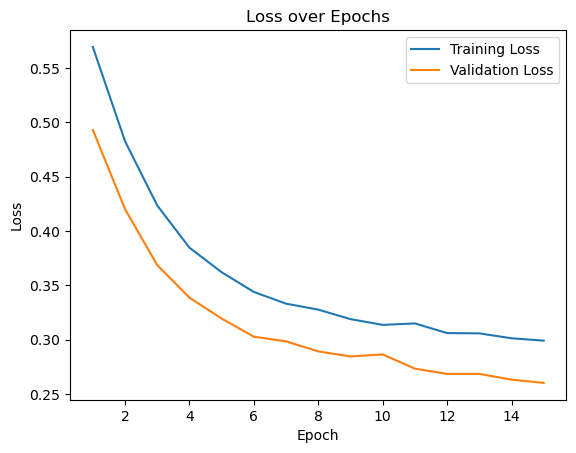

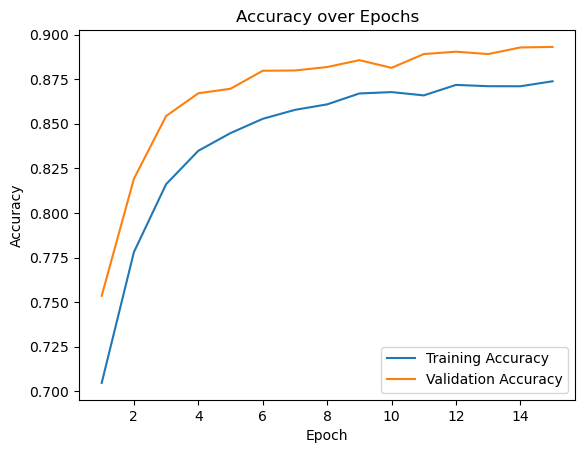

In [14]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

#plotting loss
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

#plotting accuracy
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()







##### The following cells comprise of the data preparation

#### Exploratory Data Analysis

##### Train/Val/Test Split

##### Fine Tuning BERT

Text(0, 0.5, 'Number of texts')

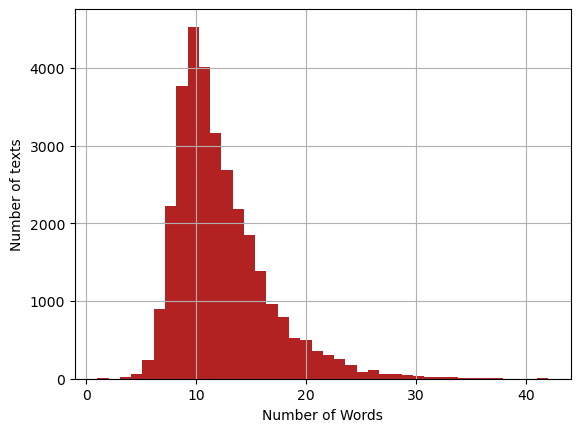

In [6]:
seq_len = [len(text.split()) for text in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In the histogram above, we can see that the majority of the titles have a word length of under 15. Given that, we will set the max title length to 15 and tokenize each title. 

##### Data loader structure definition 
below we will..
- define batch size
- wrap tensors 
- use sampler for sampling the data during training 
- define dataloaders for all three sets of data


#### Below is the code to define the Bert architecture

##### Below we are identifying our training and evaluation functions

##### Model Training and prediction

#### Inference on new politifact dataset

In [15]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score